In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import maxwell, gaussian_kde
import astropy.constants as cons

# Function

In [2]:
class PowerLawPDF(object): # Taken from https://github.com/farr/BumpCosmology/blob/main/src/scripts/mock_injections.py
    def __init__(self, alpha, a, b):
        assert alpha > 1

        self.alpha = alpha
        self.a = a
        self.b = b

        self.norm = (self.a - (self.a/self.b)**self.alpha*self.b)/(self.a*(self.alpha-1))

    def __call__(self, x):
        return (self.a/x)**self.alpha/self.a/self.norm
    
    def icdf(self, c):
        return ((self.a**self.alpha*self.b*c + self.a*self.b**self.alpha*(1-c))/(self.a*self.b)**self.alpha)**(1/(1-self.alpha))

rng = np.random.default_rng(333165393797366967556667466879860422123)

In [3]:
def fSN1(powerlawindex, mmin, mmax, mNSmin, mNSmax, qmin, qmax,
         logamin, logamax, fcore, beta, sigmakick, ndraw=10**6):
    AU_to_m = 1.496e+11
    Solar_M_in_kg = 1.989e+30

    m1i = PowerLawPDF(powerlawindex, mmin, mmax).icdf(rng.uniform(low=0, high=1, size=ndraw)) # Solar mass
    m1i = m1i[m1i>mNSmin]
    m1i = m1i[m1i<mNSmax]
    m1 = fcore*m1i
    ndraw = m1.shape[0]
    
    Qi = np.random.uniform(0.01, 1.0, size=ndraw)
    Q = (Qi+beta*(1-fcore))/fcore
    
    logai = rng.uniform(low=np.log(0.01), high=np.log(1000), size=ndraw) # AU
    ai = np.exp(logai)
    a = ai*(1/fcore**2)*((Q+1)/(fcore*Q+1))*np.exp(2*Q*(fcore-1))

    vorb = ((cons.G.value*Solar_M_in_kg/AU_to_m) * m1 * (1+Q) / a)**0.5/1000 # km/s
    vkick = maxwell(loc=0., scale=sigmakick).rvs(size=ndraw) # km/s
    x = vkick - vorb
    kernel = gaussian_kde(x)
    return 1-kernel.integrate_box_1d(low=0, high=100000), ndraw

# Fiducial
print(fSN1(powerlawindex=2.7, mmin=1.0, mmax=300.0, mNSmin=6.0, mNSmax=20.0, qmin=0.01, qmax=1.0,
           logamin=np.log(0.01), logamax=np.log(1000), fcore=0.35, beta=0.5, sigmakick=265.0, ndraw=10**6))

(0.20331315218521995, 41384)


In [4]:
for qmin in [0.01, 0.2]:
    if qmin==0.01:
        print('With SMT:', fSN1(powerlawindex=2.7, mmin=1.0, mmax=300.0, mNSmin=6.0, mNSmax=20.0,
                                qmin=qmin, qmax=1.0, logamin=np.log(0.01), logamax=np.log(1000),
                                fcore=0.35, beta=0.5, sigmakick=265.0))
    if qmin==0.2:
        print('Without SMT:', fSN1(powerlawindex=2.7, mmin=1.0, mmax=300.0, mNSmin=6.0, mNSmax=20.0,
                                qmin=qmin, qmax=1.0, logamin=np.log(0.01), logamax=np.log(1000),
                                fcore=0.35, beta=0.5, sigmakick=265.0))

With SMT: (0.19896839647922038, 41311)
Without SMT: (0.20299735904521632, 41303)


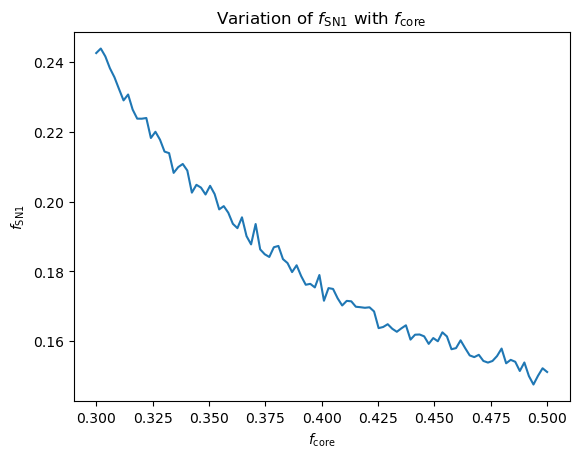

In [5]:
fcorearray = np.linspace(0.3, 0.5, 100)
fSN1array = []
for fcore in fcorearray:
    fSN1array.append(fSN1(powerlawindex=2.7, mmin=1.0, mmax=300.0, mNSmin=6.0, mNSmax=20.0,
                                qmin=0.2, qmax=1.0, logamin=np.log(0.01), logamax=np.log(1000),
                                fcore=fcore, beta=0.5, sigmakick=265.0)[0])
fSN1array = np.array(fSN1array)
plt.plot(fcorearray, fSN1array)
plt.xlabel(r'$f_{\text{core}}$')
plt.ylabel(r'$f_{\text{SN1}}$')
plt.title(r'Variation of $f_{\text{SN1}}$ with $f_{\text{core}}$')
plt.savefig('../plots/fcorefSN1.pdf');

## $f_{core}$ increases, $m_1$ increase, $Q$ decreases, $a$ and hence $v_{orb}$ is a complicated function of $f_{core}$. For our range of interest, if $f_{core}$ increases, $v_{orb}$ increases, $f_{SN1}$ decreases.

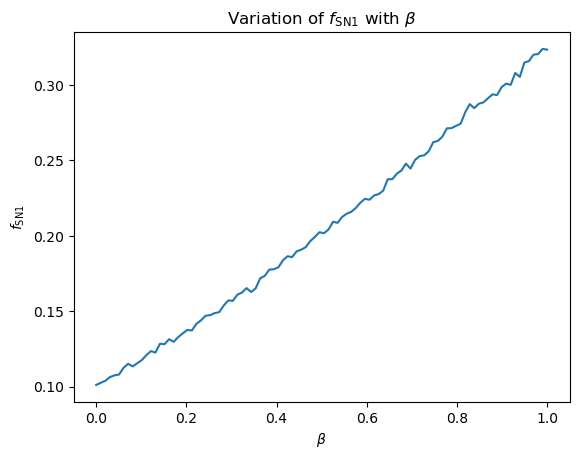

In [6]:
betaarray = np.linspace(0.0, 1.0, 100)
fSN1array1 = []
for beta in betaarray:
    fSN1array1.append(fSN1(powerlawindex=2.7, mmin=1.0, mmax=300.0, mNSmin=6.0, mNSmax=20.0,
                                qmin=0.2, qmax=1.0, logamin=np.log(0.01), logamax=np.log(1000),
                                fcore=0.35, beta=beta, sigmakick=265.0)[0])
fSN1array1 = np.array(fSN1array1)
plt.plot(betaarray, fSN1array1)
plt.xlabel(r'$\beta$')
plt.ylabel(r'$f_{\text{SN1}}$')
plt.title(r'Variation of $f_{\text{SN1}}$ with $\beta$')
plt.savefig('../plots/betafSN1.pdf');

## $\beta$ increases, $Q$ increases, $v_{orb}$ increases, $f_{SN1}$ increases.

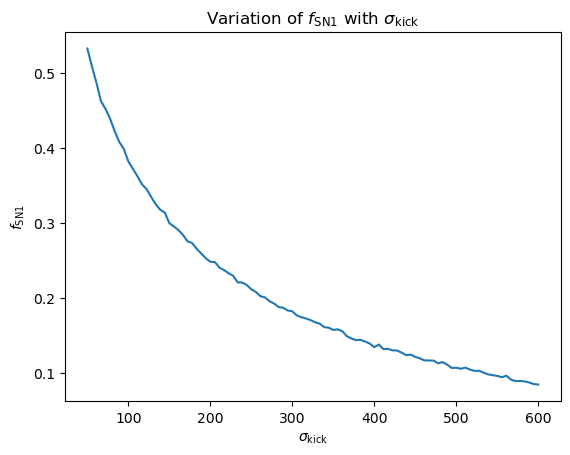

In [7]:
sigmakickarray = np.linspace(50, 600, 100)
fSN1array2 = []
for sigmakick in sigmakickarray:
    fSN1array2.append(fSN1(powerlawindex=2.7, mmin=1.0, mmax=300.0, mNSmin=6.0, mNSmax=20.0,
                                qmin=0.2, qmax=1.0, logamin=np.log(0.01), logamax=np.log(1000),
                                fcore=0.35, beta=0.5, sigmakick=sigmakick)[0])
fSN1array2 = np.array(fSN1array2)
plt.plot(sigmakickarray, fSN1array2)
plt.xlabel(r'$\sigma_{\text{kick}}$')
plt.ylabel(r'$f_{\text{SN1}}$')
plt.title(r'Variation of $f_{\text{SN1}}$ with $\sigma_{\text{kick}}$')
plt.savefig('../plots/sigmakickfSN1.pdf');

## $\sigma_{kick}$ inceases, $v_{kick}$ inceases, $f_{SN1}$ decreases.